In [1]:
## This file will have all the functions needed to load, view, and evaluate any saved models
## for the first two model sets - the NN models. 
## First NN model set includes FTD data
## Second NN model set did not train with FTD data

## Each model_set has its lowest, and highest accuracy version saved. 

## ['w_FTD']model_2 and ['woFTD']model_4 should be the go-to choices.

## ['w_FTD']model_2 is the lowest accuracy version of models INCLUDING ftd data. 
## ['woFTD']model_4 is the lowest accuracy version of models WITHOUT ftd data. 

## ['w_FTD']model_1 and ['woFTD']model_3 are the highest accuracy iterations of their respective data. 
## These can be useful to see how well each model performed - if the accuracy is only slightly higher
## for model_1 , relative to model_2, that means the model's training and performance is consistent. 

In [2]:
## There are five folders with useful model data that will be used for the project presentation
## All located in '../Model_Data/'

## There are two sets of Neural Network (NN) models which are direct improvements upon the original machine-learning 
## models from FTD_Project_2. The difference between each set, which should be obvious from the title path, is one set 
## of models was trained with and including the SEC's FTD data, while the second set had the FTD data omitted from the 
## models. Each model is improved relative to FTD_Project_2, because now they not only attempt to predict the close 
## price with the data provided, but now they attempt to forecast the close price 1, 2, 5, or 10 days in advance. 

## Model locations: 
## Model_1: 
# path_1 = Path('../Model_Data/Date_Test_NN_w_FTD_all/')   ## Contains models trained with FTD data
## Model_2: 
# path_2 = Path('../Model_Data/Date_Test_NN_noFTD_all/')   ## Contains models trained without FTD data





## The third set of models shares a similarity with the previous two NN models - it used the same dataset (up to Dec31st)
## to train, however, instead of a neural network (NN) model, it is an LSTM model designed to supplement the performance
## of the NN models and compare its results alongside. 
## This third model does not predict/forecast data in quite the same way as the NN models - it should be used as a 
## comparison or addition to the 1-day NN models listed above. 
## It also acts as demonstration that LSTM-models can also be used, in addition to NN, to predict/track the closing price
## using our FTD, Short Interest, and Historical Pricing dataset. 

## Model Location:
## Model_3: 
# path_3 = Path('../Model_Data/LSTM_Model_Data_1/')  ## Contains LSTM models trained with FTD data, up to Dec31st. 



## The fourth set of models were designed after early evaluations of models _1 and _2. The purpose of the first 
## two models was to compare the effect of removing the FTD Data from the features of the machine learning model, 
## and early evaluations showed that, while definitely improving the accuracy of the models when included, the 
## FTD data was not necessary or required in order to achieve accurate price tracking / predictions. 
## So, the fourth (and fifth) models were designed as concept of how these models could genuinely be used to 
## make predictions, select stock symbols, plan a buying strategy, and actually trade using these models that 
## have been created over the course of this project. 

## Model Location:
# Model_4:
# path_4 = Path('../Model_Data/Feb2022_NN_models/') ## Contians NN models, capable of taking January's data and making
                                                    ## predictions 1, 2, 5, or 10 trading days into February. 
    
## The fifth set of models were created for the same purpose as the fourth, and perform a 10-day forecast of close price 
## for a given stock. Instead of a NN model, this is an improved-upon (relative to Model_3) LSTM model that alongside 
## our NN can be used to forecast stock price predictions, with enough accuracy that one could consider trading off 
## of these models. 

## Model Location:
# Model_5:
# path_5 = Path('../Model_Data/Feb2022_LSTM_models_1/'

In [3]:
import pandas as pd
import numpy as np

from pathlib import Path

In [4]:
# Machine-learning specific imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [5]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [6]:
## API Imports 
import os
import requests
import json

from dotenv import load_dotenv
load_dotenv()

## FMP Constants 
fmpbase_urlv3 = 'https://fmpcloud.io/api/v3/'
fmpbase_urlv4 = 'https://fmpcloud.io/api/v4/'
api_key = os.getenv("FMP_CLOUD_API_KEY")

start_date = '2022-01-01'
end_date = '2022-01-31'

## FMP Functions 
def get_FMP_historical_data(symbol, startDate=start_date, endDate=end_date, apiKey=api_key):
    url_hist_price = fmpbase_urlv3+'historical-price-full/'
    url_hist_query_with_date = url_hist_price+symbol+'?from='+startDate+'&to='+endDate+'&apikey='+apiKey
    resp_data = requests.get(url_hist_query_with_date)
    json_ = resp_data.json()
    data = json_['historical']
    df = pd.DataFrame(data)
    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.reindex(index=df.index[::-1]) ## Reverse the DataFrame 
    df.set_index('Date',inplace=True)
    df.drop(columns='label',inplace=True)
    return df

In [7]:
def get_data(symbol, n_days):
    path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')
    data = load_obj(path)
    df = data[symbol]
    
    df_close = df[['close']]
    df_close = df_close.reset_index().rename(columns={"Date": "Close_Date"})
    
    features_df = df.reset_index().drop(columns=['close','adjClose'])
    
    new_close_df = df_close.iloc[n_days: , :].reset_index(drop=True)
    
    ## Prevent multiple API calls each time, but use API when needed. 
    try:
        path = Path('../FilesExport_Updated_API_data/'+symbol+'_jan_2022.pkl')
        api_df = load_obj(path)
    except:
        api_df = get_FMP_historical_data(symbol)
    

    new_data = api_df[['close']]
    new_data = new_data.reset_index().rename(columns={"Date": "Close_Date"})
    new_data = new_data.iloc[0:n_days]
    
    new_close_df = new_close_df.append(new_data, ignore_index=True)
    

    
    return features_df, new_close_df

## Dropping QUANTITY_FAILS from dataframe before machine learning 

def prepare_data_no_FTD(symbol,n_days,return_data=False):
    features_df, new_close_df = get_data(symbol,n_days)
    
    X = features_df.drop(columns={'Date','QUANTITY_FAILS'}).values
    y = new_close_df['close'].values
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    if return_data == True:
        return X, y, features_df, new_close_df
    else:
        return X, y
    
def prepare_data(symbol,n_days,return_data=False):
    features_df, new_close_df = get_data(symbol,n_days)
    
    X = features_df.drop(columns='Date').values
    y = new_close_df['close'].values
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    if return_data == True:
        return X, y, features_df, new_close_df
    else:
        return X, y

def load_and_predict_model(symbol,n_days,
                       include_model_obj=True,  ## Return the loaded model itself as part of data - use false if only looking for acc values. 
                       return_indvidual_model=False, ## Will return only a single model if true 
                       model_='model_2'):       ## Indicates which model to return 
     
    
    data_dict = {}

    export_path='../Model_Data/Date_Test_NN_w_FTD_all/High_Acc/'
    model_type = 'NN'
    n_days_string = str(n_days)
    export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

    file_path = Path(export_path_prefix+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model1 = model_from_json(model_json)

    # load weights into new model
    file_path = Path(export_path_prefix+'_model_weights.h5')
    loaded_model1.load_weights(file_path)

    ## Load model summary 
    file_path = Path(export_path_prefix+'_model_summary.pkl')
    model_summary1 = load_obj(file_path)

    X1 , y1, features1, close_df1 = prepare_data(symbol,n_days,return_data=True)


    close_df1["predicted"] = loaded_model1.predict(X1)
    close_df1.set_index('Close_Date',inplace=True)

    prediction_df1 = close_df1[['close','predicted']]



    export_path='../Model_Data/Date_Test_NN_w_FTD_all/Low_Acc/'
    model_type = 'NN'
    n_days_string = str(n_days)
    export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

    file_path = Path(export_path_prefix+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model2 = model_from_json(model_json)

    # load weights into new model
    file_path = Path(export_path_prefix+'_model_weights.h5')
    loaded_model2.load_weights(file_path)

    ## Load model summary 
    file_path = Path(export_path_prefix+'_model_summary.pkl')
    model_summary2 = load_obj(file_path)

    #X2 , y2, features2, close_df2 = prepare_data(symbol,n_days,return_data=True)

    close_df1["predicted"] = loaded_model2.predict(X1)
    #close_df.set_index('Close_Date',inplace=True) ## Alreayd set above 

    prediction_df2 = close_df1[['close','predicted']]


    export_path='../Model_Data/Date_Test_NN_noFTD_all/High_Acc/'
    model_type = 'NN'
    n_days_string = str(n_days)
    export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

    file_path = Path(export_path_prefix+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model3 = model_from_json(model_json)

    # load weights into new model
    file_path = Path(export_path_prefix+'_model_weights.h5')
    loaded_model3.load_weights(file_path)

    ## Load model summary 
    file_path = Path(export_path_prefix+'_model_summary.pkl')
    model_summary3 = load_obj(file_path)

    X2 , y2, features2, close_df2 = prepare_data_no_FTD(symbol,n_days,return_data=True)


    close_df2["predicted"] = loaded_model3.predict(X2)
    close_df2.set_index('Close_Date',inplace=True)

    prediction_df3 = close_df2[['close','predicted']]



    export_path='../Model_Data/Date_Test_NN_noFTD_all/Low_Acc/'
    model_type = 'NN'
    n_days_string = str(n_days)
    export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

    file_path = Path(export_path_prefix+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model4 = model_from_json(model_json)

    # load weights into new model
    file_path = Path(export_path_prefix+'_model_weights.h5')
    loaded_model4.load_weights(file_path)

    ## Load model summary 
    file_path = Path(export_path_prefix+'_model_summary.pkl')
    model_summary4 = load_obj(file_path)

    #X2 , y2, features2, close_df2 = prepare_data_no_FTD(symbol,n_days,return_data=True)

    close_df2["predicted"] = loaded_model4.predict(X2)
    #close_df2.set_index('Close_Date',inplace=True)

    prediction_df4 = close_df2[['close','predicted']]
    
    
    
    ## Instead of returning 4 dataframes, return one big dict containing all data needed 
    ## for one symbol 
    
    if include_model_obj == True:
    
        data_dict[symbol] = {
            'w_FTD': 
            {
                'model_1': 
                {
                    'loaded_model':loaded_model1,
                    'model_summary':model_summary1,
                    'prediction_df':prediction_df1,
                },
                'model_2': 
                {
                    'loaded_model':loaded_model2,
                    'model_summary':model_summary2,
                    'prediction_df':prediction_df2,
                }
            },
            'woFTD': 
            {
                'model_3': 
                {
                    'loaded_model':loaded_model3,
                    'model_summary':model_summary3,
                    'prediction_df':prediction_df3,
                },
                'model_4': 
                {
                    'loaded_model':loaded_model4,
                    'model_summary':model_summary4,
                    'prediction_df':prediction_df4,
                }
            }
        }
        
    elif include_model_obj==False:
        data_dict[symbol] = {
            'w_FTD': 
            {
                'model_1': 
                {
                    #'loaded_model':loaded_model1,
                    'model_summary':model_summary1,
                    'prediction_df':prediction_df1,
                },
                'model_2': 
                {
                    #'loaded_model':loaded_model2,
                    'model_summary':model_summary2,
                    'prediction_df':prediction_df2,
                }
            },
            'woFTD': 
            {
                'model_3': 
                {
                    #'loaded_model':loaded_model3,
                    'model_summary':model_summary3,
                    'prediction_df':prediction_df3,
                },
                'model_4': 
                {
                    #'loaded_model':loaded_model4,
                    'model_summary':model_summary4,
                    'prediction_df':prediction_df4,
                }
            }
        }
    
    
    if return_indvidual_model == True:
        if model_ == 'model_1' or 'model_2':
            return_data = data_dict[symbol]['w_FTD'][model_]
            return return_data
        elif model_ == 'model_3' or 'model_4':
            return_data = data_dict[symbol]['woFTD'][model_]
            return return_data
    else:   
        return data_dict

In [8]:
## How to use functions: 

## Need to give it a symbol that was included in 
## Import symbol list 
path = Path('../Resources/06_01_ML_symbol_success_list.pkl')
symbol_list = load_obj(path)
#len(symbol_list)

## NOTE - 5 symbols failed a 10-day prediction and may not succeed if attempting to iterate
## the entire 06_01_ML_symbol_success_list
## can also use: 
## Export symbol_accuracy_dict
# path = Path('../Resources/NN_noFTDall_symbol_list.pkl')
# save_obj(symbol_accuracy_dict,path)

## and

# ## Export symbol_accuracy_dict
# path = Path('../Resources/NN_w_FTDall_symbol_list.pkl')
# save_obj(symbol_accuracy_dict,path)

## to load dictionaries (not lists, despite the name) containing basic data on the models ran, 
## and successful symbols available to run. 

## Alternatively, just use a try loop and use 06_01_ML_symbol_success_list if iterating through models. 

In [9]:
## Export symbol_accuracy_dict
symbol_path = Path('../Resources/NN_noFTDall_symbol_list.pkl')
NN_symbols = load_obj(symbol_path)
len(NN_symbols) 

3069

In [10]:
len(NN_symbols) /4

767.25

In [11]:
test_symbol = 'GME'
n_days = 10 ## Has to be 1, 2, 5, or 10      ## n_days is the # of days to predict/forecast 

## These NN models predict n_days into Janurary, as they've trained using data up to Dec 31st. 
## The "actual" close prices are available for January, so we can get an accurate representation
## using these models, of how well they can predict a future price. 

In [12]:
## Get all model data:
symbol = test_symbol

## set include_model_obj==True to include all 4 model objects in return 
test_data_dict = load_and_predict_model(symbol,n_days,include_model_obj=True)
#test_data_dict

In [13]:
test_data_dict

{'GME': {'w_FTD': {'model_1': {'loaded_model': <keras.engine.sequential.Sequential at 0x200bed558c8>,
    'model_summary': {'model_accuracy': 630.6928100585938,
     'n_days': 10,
     'validation_split_value': 0.1,
     'epochs_value': 200},
    'prediction_df':                  close   predicted
    Close_Date                        
    2016-02-17   28.740000   27.811636
    2016-02-18   29.240000   28.488400
    2016-02-19   28.190001   29.794245
    2016-02-22   29.209999   29.783825
    2016-02-23   29.440001   30.302464
    ...                ...         ...
    2022-01-10  131.150000  174.682526
    2022-01-11  130.300000  179.135376
    2022-01-12  128.060000  201.422287
    2022-01-13  122.480000  212.683563
    2022-01-14  116.650000  192.912033
    
    [1491 rows x 2 columns]},
   'model_2': {'loaded_model': <keras.engine.sequential.Sequential at 0x200c6359ec8>,
    'model_summary': {'model_accuracy': 504.6863708496094,
     'n_days': 10,
     'validation_split_value': 0.1

In [14]:
## With the data_dict loaded, can access individual model objects:

## Use either w_FTD or woFTD , depending whether you want FTD data included, or not
## ['w_FTD']model_2 and ['woFTD']model_4 should be the go-to choices.
## ['w_FTD']model_2 is the lowest accuracy version of models INCLUDING ftd data. 
## ['woFTD']model_4 is the lowest accuracy version of models WITHOUT ftd data. 
## ['w_FTD']model_1 and ['woFTD']model_3 are the highest accuracy iterations of their respective data. 

model_2_obj = test_data_dict[symbol]['w_FTD']['model_2']['loaded_model']

In [15]:
## Can load model_summary's - useful for loading accuracy data 
model_2_summary = test_data_dict[symbol]['w_FTD']['model_2']['model_summary']
model_2_summary['model_accuracy']

504.6863708496094

In [16]:
## How to see predictions
model_2_pred_df = test_data_dict[symbol]['w_FTD']['model_2']['prediction_df']
model_2_pred_df.tail(n_days+5)

,close,predicted
Close_Date,,
2021-12-27,148.31,163.696060
2021-12-28,146.46,141.745193
2021-12-29,153.93,148.832596
2021-12-30,155.33,159.506393
2021-12-31,148.39,160.927475
2022-01-03,152.84,175.326050
2022-01-04,148.91,181.976608
2022-01-05,129.37,178.835785
2022-01-06,131.03,175.967651


<AxesSubplot:xlabel='Close_Date'>

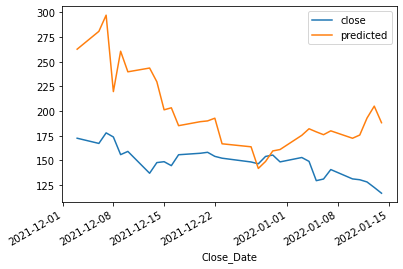

In [17]:
## How to plot predictions
## Get dataframe, then
model_2_pred_df.tail(30).plot(use_index=True)

In [19]:
symbol = 'XRT'
## Use function to only load model_2 
model_2_data = load_and_predict_model(symbol,
                                  n_days,
                                  include_model_obj=True,
                                  return_indvidual_model=True,
                                  model_='model_2')

In [20]:
loaded_model = model_2_data['loaded_model']
model_summary= model_2_data['model_summary']
prediction_df= model_2_data['prediction_df']
accuracy = model_summary['model_accuracy']
print(accuracy)

7.677979469299316


<AxesSubplot:xlabel='Close_Date'>

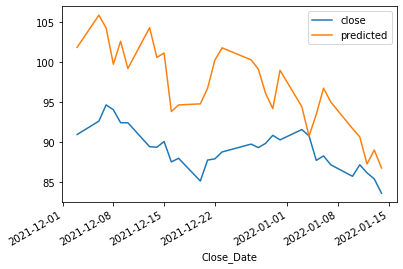

In [21]:
prediction_df.tail(30).plot(use_index=True)